In [1]:
import os
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

In [2]:
# 설정: 대상 동물과 데이터 경로 설정
target_animal = 'dog'  # 'cat', 'dog' 중 선택

# 경로 설정
main_path = os.path.join(os.getcwd().rsplit(
    'FurEmotion-AI')[0], 'FurEmotion-AI\\FurEmotion-AI')  # 'c:\\Users\\fisho\\FurEmotion-AI\\FurEmotion-AI'
# 'c:\\Users\\fisho\\FurEmotion-AI\\FurEmotion-AI\\image_data\\cat'
data_path = os.path.join(main_path, 'image_data', target_animal)

sys.path.append(main_path)

if not os.path.exists(data_path):
    raise ValueError(f'No such animal data path: {data_path}')

state_list = [dir_path for dir_path in os.listdir(
    data_path) if os.path.isdir(os.path.join(data_path, dir_path))]
print(f"분류할 상태 목록: {state_list}")

분류할 상태 목록: ['hostile', 'relax', 'whining']


c:\Users\fisho\FurEmotion-AI\FurEmotion-AI\image_data\dog\relax\relax_46.png


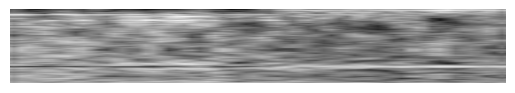

Image shape: (128, 862, 3)


In [3]:
def display_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()


random_file = np.random.choice([file for file in os.listdir(
    os.path.join(data_path, state_list[1])) if file.endswith('.png')])
test_file_path = os.path.join(data_path, state_list[1], str(random_file))
print(test_file_path)

display_image(test_file_path)

# print image shape
image = Image.open(test_file_path)
image_array = np.array(image)
print(f"Image shape: {image_array.shape}")

img_height, img_width, img_channel = image_array.shape

In [4]:
# 하이퍼파라미터 설정
batch_size = 32

# 데이터셋 로드 및 분할 (9:1 비율로 학습 및 테스트 데이터 분할)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.15,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.15,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
print(f"클래스 이름: {class_names}")

# 데이터 성능 최적화
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 데이터 전처리 (ResNet50의 입력 형식에 맞게 조정)
from tensorflow.keras.applications.resnet50 import preprocess_input


def preprocess(image, label):
    image = preprocess_input(image)
    return image, label


train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)

Found 469 files belonging to 3 classes.
Using 399 files for training.
Found 469 files belonging to 3 classes.
Using 70 files for validation.
클래스 이름: ['hostile', 'relax', 'whining']


In [5]:
test_img = np.array(Image.open(os.path.join(
    data_path, state_list[0], f'{state_list[0]}_1.png')))
test_img.shape

(128, 862, 3)

In [ ]:
num_classes = len(class_names)

inputs = tf.keras.Input(shape=(img_height, img_width, 3))

# Convolution layer (VGG)
inner = tf.keras.layers.Conv2D(16, (3, 3), padding='same', name='conv1',
                               kernel_initializer='he_normal')(inputs)  # (None, 128, 64, 64)
inner = tf.keras.layers.BatchNormalization()(inner)
inner = tf.keras.layers.Activation('relu')(inner)
inner = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='max1')(inner)  # (None,64, 32, 64)

inner = tf.keras.layers.Conv2D(32, (3, 3), padding='same', name='conv2',
                               kernel_initializer='he_normal')(inner)  # (None, 64, 32, 128)
inner = tf.keras.layers.BatchNormalization()(inner)
inner = tf.keras.layers.Activation('relu')(inner)
inner = tf.keras.layers.MaxPooling2D(pool_size=(
    2, 2), name='max2')(inner)  # (None, 32, 16, 128)

inner = tf.keras.layers.Conv2D(64, (3, 3), padding='same', name='conv3',
                               kernel_initializer='he_normal')(inner)  # (None, 32, 16, 256)
inner = tf.keras.layers.BatchNormalization()(inner)
inner = tf.keras.layers.Activation('relu')(inner)

inner = tf.keras.layers.Conv2D(128, (3, 3), padding='same', name='conv4',
                               kernel_initializer='he_normal')(inner)  # (None, 32, 16, 256)
inner = tf.keras.layers.BatchNormalization()(inner)
inner = tf.keras.layers.Activation('relu')(inner)
inner = tf.keras.layers.MaxPooling2D(pool_size=(
    1, 2), name='max3')(inner)  # (None, 32, 8, 256)

inner = tf.keras.layers.Conv2D(256, (3, 3), padding='same', name='conv5',
                               kernel_initializer='he_normal')(inner)  # (None, 32, 8, 512)
# inner = tf.keras.layers.BatchNormalization()(inner)
inner = tf.keras.layers.Activation('relu')(inner)

inner = tf.keras.layers.Conv2D(512, (3, 3), padding='same', name='conv6')(
    inner)  # (None, 32, 8, 512)
# inner = tf.keras.layers.BatchNormalization()(inner)
inner = tf.keras.layers.Activation('relu')(inner)
inner = tf.keras.layers.MaxPooling2D(pool_size=(1, 2), name='max4')(inner)  # (None, 32, 4, 512)


# CNN to RNN
inner = tf.keras.layers.Reshape(target_shape=(
    (32, -1)), name='reshape')(inner)  # (None, 32, 2048)
inner = tf.keras.layers.Dense(
    64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)  # (None, 32, 64)

# RNN layer
lstm_1 = tf.keras.layers.LSTM(256, return_sequences=True,
                              kernel_initializer='he_normal', name='lstm1')(inner)  # (None, 32, 512)
lstm_1b = tf.keras.layers.LSTM(256, return_sequences=True, go_backwards=True,
                               kernel_initializer='he_normal', name='lstm1_b')(inner)
reversed_lstm_1b = tf.keras.layers.Lambda(
    lambda inputTensor: tf.keras.backend.reverse(inputTensor, axes=1))(lstm_1b)

lstm1_merged = tf.keras.layers.add(
    [lstm_1, reversed_lstm_1b])  # (None, 32, 512)
lstm1_merged = tf.keras.layers.BatchNormalization()(lstm1_merged)

lstm_2 = tf.keras.layers.LSTM(256, return_sequences=True,
                              kernel_initializer='he_normal', name='lstm2')(lstm1_merged)
lstm_2b = tf.keras.layers.LSTM(256, return_sequences=True, go_backwards=True,
                               kernel_initializer='he_normal', name='lstm2_b')(lstm1_merged)
reversed_lstm_2b = tf.keras.layers.Lambda(
    lambda inputTensor: tf.keras.backend.reverse(inputTensor, axes=1))(lstm_2b)

lstm2_merged = tf.keras.layers.concatenate(
    [lstm_2, reversed_lstm_2b])  # (None, 32, 1024)
lstm2_merged = tf.keras.layers.BatchNormalization()(lstm2_merged)

# transforms RNN output to character activations:
inner = tf.keras.layers.Flatten()(lstm2_merged)  # (None, 32*63)
pred = tf.keras.layers.Dense(num_classes, kernel_initializer='he_normal',
                             name='dense2', activation="softmax")(inner)  # (None, 63)

model = tf.keras.Model(inputs=inputs, outputs=pred)

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 862, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 128, 862, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 862, 16)         64        ['conv1[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 862, 16)         0         ['batch_normalization[0]

In [7]:
# 모델 훈련
epochs = 3
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/3


13/13 [==============================] - 71s 5s/step - loss: 1.3862 - accuracy: 0.3659 - val_loss: 0.9428 - val_accuracy: 0.5857
Epoch 2/3
13/13 [==============================] - 65s 5s/step - loss: 1.1518 - accuracy: 0.4712 - val_loss: 0.9817 - val_accuracy: 0.5714
Epoch 3/3
13/13 [==============================] - 67s 5s/step - loss: 1.1065 - accuracy: 0.4511 - val_loss: 1.3441 - val_accuracy: 0.3571


In [8]:
# 모델 저장
model.save('CRNN_finetuned.h5')

c:\Users\fisho\anaconda3\envs\furemotion\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


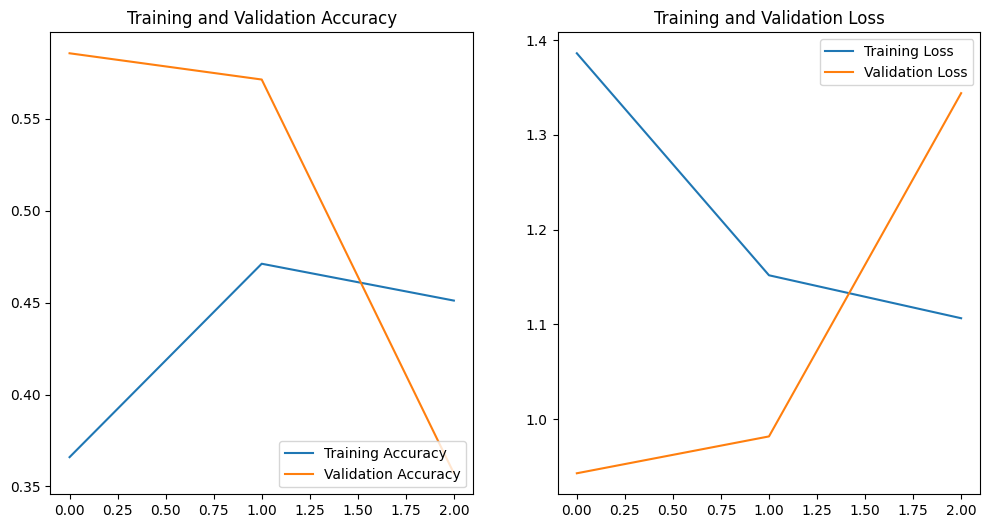

In [9]:
# 학습 결과 시각화 (정확도 및 손실 그래프)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 2s 2s/step
(32, 128, 862, 3)
1/1 [==============================] - 1s 944ms/step
(32, 128, 862, 3)
1/1 [==============================] - 2s 2s/step
(6, 128, 862, 3)


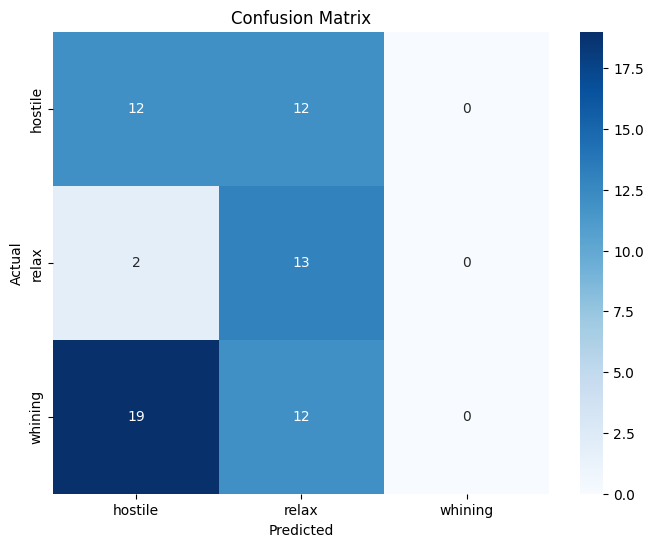

Classification Report
              precision    recall  f1-score   support

     hostile       0.36      0.50      0.42        24
       relax       0.35      0.87      0.50        15
     whining       0.00      0.00      0.00        31

    accuracy                           0.36        70
   macro avg       0.24      0.46      0.31        70
weighted avg       0.20      0.36      0.25        70



c:\Users\fisho\anaconda3\envs\furemotion\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\fisho\anaconda3\envs\furemotion\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\fisho\anaconda3\envs\furemotion\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

In [10]:
# 모델 평가 및 혼동 행렬 계산
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    print(images.shape)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names,
            yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print('Classification Report')
print(classification_report(y_true, y_pred, target_names=class_names))